# Imports and Helper/Utility Methods

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import random
import time
import math

from scipy.ndimage.measurements import label

from features import SupportVectorClassifier
from features import FeatureExtractor
from features import DataLoader
from features import ImageSampler

from run import VehicleDetectionPipeline

%load_ext autoreload
%autoreload 2

def load_image(image_path, color_conversion=cv2.COLOR_BGR2RGB):
    """Utility method for opening an image using specified color conversion"""
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, color_conversion) 

def show_images(images, per_row=None, main_title=None):
    """ Utility method for showing multiple images"""
    
    if per_row is None:
        per_row = math.ceil(math.sqrt(len(images)))
        
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis("off")

        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Helper method to draw given boxes ontop of an image"""
    # Make a copy of the image
    imcopy = np.copy(img)
    count = 0

    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        count += 1
    # Return the image copy with boxes drawn
    return imcopy


# Loading and Exploring The Data Set

Finished loading 17760 images in 0.8 seconds.


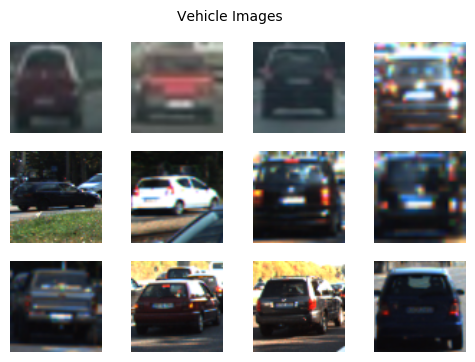

Vehicle Images:
   Count:       8792 of 17760 (49.50%)
   Value Range: 0 to 255
   Shape:       64 x 64





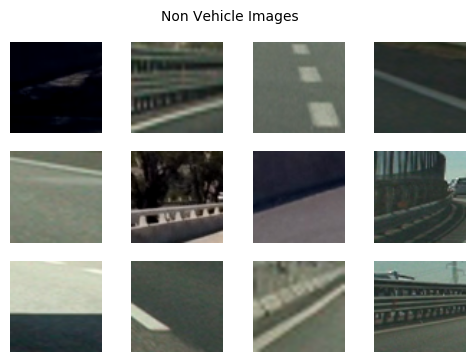

Non Vehicle Images:
   Count:       8968 of 17760 (50.50%)
   Value Range: 0 to 255
   Shape:       64 x 64





In [2]:
def preview_data(title, data, total_count, image_sample_count=12):
    count = len(data)
    percentage_of_total = count * 100.0 / total_count
    shape = data[0].shape
    minmax_range = (np.amin(data), np.amax(data))

    sample_images = []
    for i in range(0, image_sample_count):
        sample_images.append(random.choice(data))
        
    show_images(sample_images,  main_title=title)
        
    print('{:s}:'.format(title))
    print('   Count:       {:d} of {:d} ({:3.2f}%)'.format(count, total_count, percentage_of_total))
    print('   Value Range: {} to {}'.format(minmax_range[0], minmax_range[1]))
    print('   Shape:       {} x {}\n\n\n'.format(shape[0], shape[1]))
    
    return count, shape, minmax_range

pipeline = VehicleDetectionPipeline(verbose=True)
vehicle_data, non_vehicle_data, image_count = pipeline.load_training_data(vehicle_data_path="vehicles/**/*.png", 
                                                                          nonvehicle_data_path="non-vehicles/**/*.png")
# show details about each data set
result = preview_data("Vehicle Images", vehicle_data, image_count)
result = preview_data("Non Vehicle Images", non_vehicle_data, image_count)

# Extracting Features

In [3]:
# extract features for training
print("Extracting features...")

pipeline.extract_features()
vehicle_features, nonvehicle_features = pipeline.vehicle_features, pipeline.non_vehicle_features

# show shapes of feature vectors
print("Feature Vector Shape:", np.asarray(vehicle_features).shape)
print("Non Vehicle Vector Shape:", np.asarray(nonvehicle_features).shape)


Extracting features...
Finished extracting features in 93 seconds
Feature Vector Shape: (8792, 10200)
Non Vehicle Vector Shape: (8968, 10200)


# Training The Classifier

In [4]:
pipeline.train_classifier(test_size=0.25)

Finished training in 63 seconds with 99.437% accuracy.


Detected 6 windows with vehicles in 12.3 seconds.


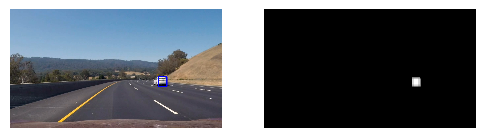

Detected 40 windows with vehicles in 12.1 seconds.


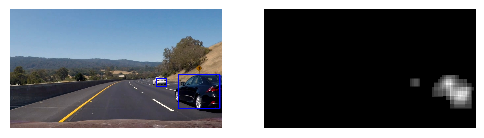

Detected 12 windows with vehicles in 12.0 seconds.


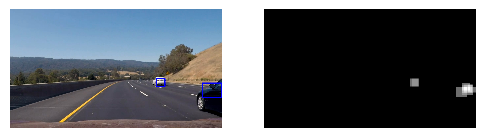

In [12]:
pipeline.set_verbose(True)
def view_some_samples(samples, view_count):
    random_samples = []
    for i in range(0, view_count):
        random_samples.append(random.choice(samples))
    show_images(images=random_samples, main_title="Detected Car Images")

image_numbers = [1920,720, 690]
for img_number in image_numbers:
    img = load_image('project_video_images/frame{:d}.jpg'.format(img_number))

    labeled_boxes, heatmap = pipeline.detect_vehicles(img, threshold=2, return_heatmap=True)
    labled_img = draw_boxes(img, labeled_boxes)
    
    show_images((labled_img,heatmap), per_row=2)


In [13]:
from run import VehicleDetectionPipeline

%load_ext autoreload
%autoreload 2

class VideoProcessor:
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.last_labeled_boxes = []
        self.current_frame_number = 0
        
    def detect_cars(self, samples, windows):
        cars, car_windows = [], []
    
        samples_features = feature_extractor.get_features(samples)
        
        for idx, feature_sample in enumerate(samples_features):
            prediction = self.classifier.predict(feature_sample)
            if prediction == 1:
                cars.append(samples[idx])
                car_windows.append(windows[idx])

        return cars, car_windows

    def process_image(self, img):
        out_img = img
        
        # update labled boxes every 15 frames
        if self.current_frame_number % 5 == 0:
            self.last_labeled_boxes = self.pipeline.detect_vehicles(img, threshold=2)
        
        # draw boxes
        for bbox in self.last_labeled_boxes:
            out_img = draw_boxes(img, self.last_labeled_boxes)
        
        self.current_frame_number += 1
        
        return out_img

pipeline.set_verbose(False)
processor = VideoProcessor(pipeline)


from moviepy.editor import VideoFileClip

output_video_filename = 'processed_project_video.mp4'
input_video = VideoFileClip('project_video.mp4')
out_clip = input_video.fl_image(processor.process_image) 
%time out_clip.write_videofile(output_video_filename, audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [50:58<00:02,  2.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

CPU times: user 50min 20s, sys: 13.7 s, total: 50min 34s
Wall time: 51min


# Sliding Windows

63


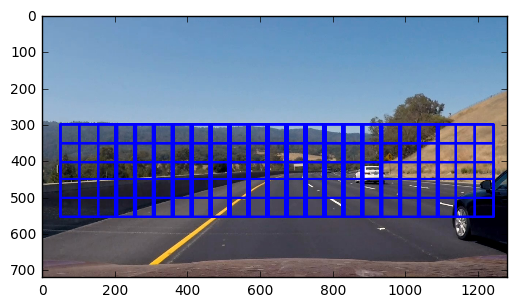

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    

windows = []
# windows = my_slider(img, x_start_stop=[0, 1280], center_y_start_stop=(550, 400), 
#                     starting_window_size=(280, 280), xy_shift_amount=(.33, .10))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[375, 500], 
                    xy_window=(64, 64), xy_overlap=(0.4, 0.4))

windows = slide_window(img, x_start_stop=[50, None], y_start_stop=[300, 600], 
                    xy_window=(150, 150), xy_overlap=(0.65, 0.65))
# windows = slide_window(img, x_start_stop=[20, None], y_start_stop=[300, 700], 
#                     xy_window=(225, 225), xy_overlap=(0.7, 0.75))
# windows += slide_window(img, x_start_stop=[None, None], y_start_stop=[300, 900], 
#                     xy_window=(300, 300), xy_overlap=(0.75, 0.75))
print(len(windows))

img = draw_boxes(img, windows)

plt.imshow(img)
plt.show()

In [8]:
import time
